<a href="https://colab.research.google.com/github/CharlotteY2003/Drug-Classifier/blob/main/Drug_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from keras.layers import *
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, LabelEncoder, OrdinalEncoder
from keras.optimizers import SGD, Adam
from keras import regularizers
from sklearn.model_selection import train_test_split, KFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#Load data

In [ ]:
data = pd.read_csv('drug200.csv')

In [ ]:
print('Before: ' + str(data.shape))
data = data.dropna()
print('After dropping missing values: ' + str(data.shape))

Before: (200, 6)
After dropping missing values: (200, 6)


#Feature Analysis

## Correlation to target values

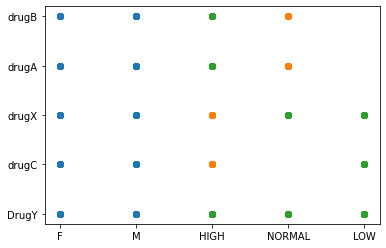

In [ ]:
plt.scatter(data.Sex.values, data.Drug.values)
plt.scatter(data.Cholesterol.values, data.Drug.values)
plt.scatter(data.BP.values, data.Drug.values)
plt.show()

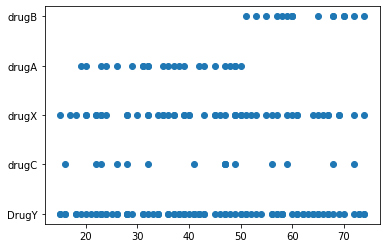

In [ ]:
plt.scatter(data.Age.values, data.Drug.values)
plt.show()

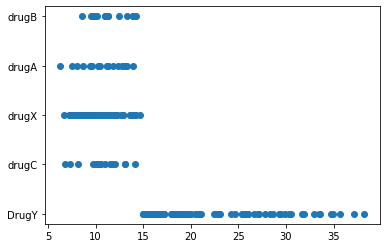

In [ ]:
plt.scatter(data.Na_to_K.values, data.Drug.values)
plt.show()

## Correlation of features to each other

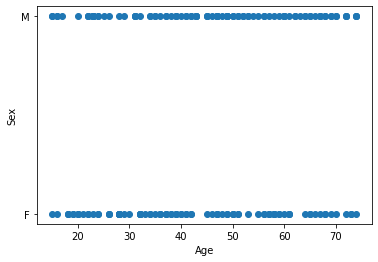

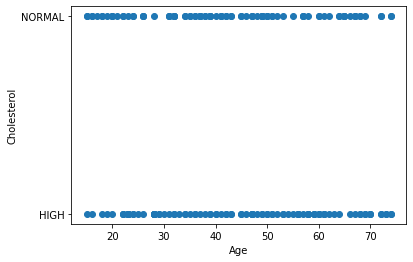

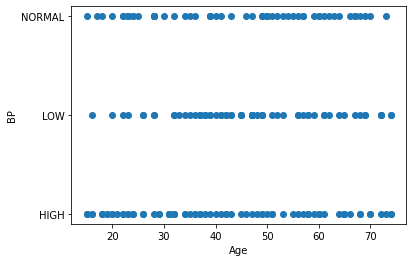

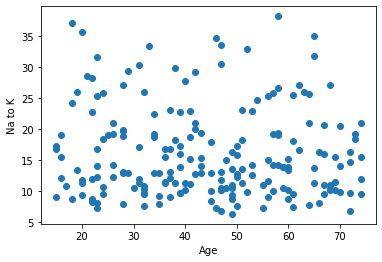

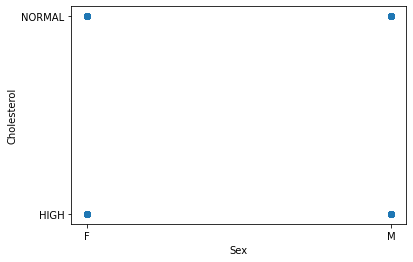

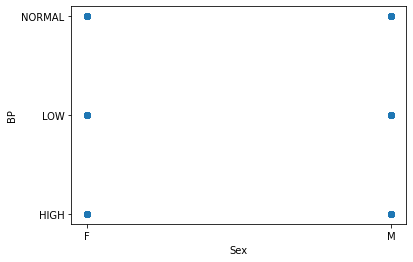

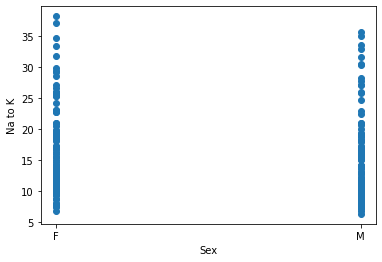

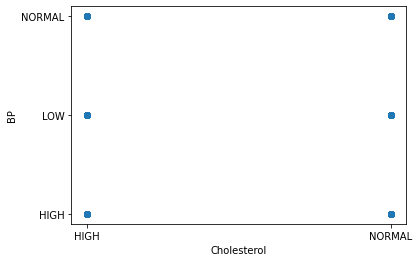

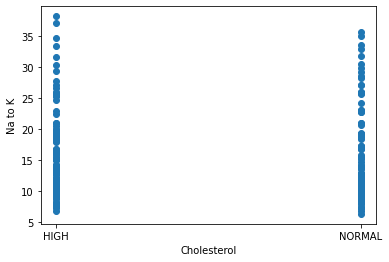

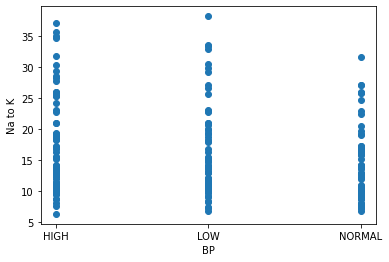

In [ ]:
features = [data.Age.values, data.Sex.values, data.Cholesterol.values, data.BP.values, data.Na_to_K.values]
names = ['Age', 'Sex', 'Cholesterol', 'BP', 'Na to K']

for feature in range(len(features)-1):
  for index in range(feature+1,len(features)):
    plt.xlabel(names[feature])
    plt.ylabel(names[index])
    plt.scatter(features[feature], features[index])
    plt.show()

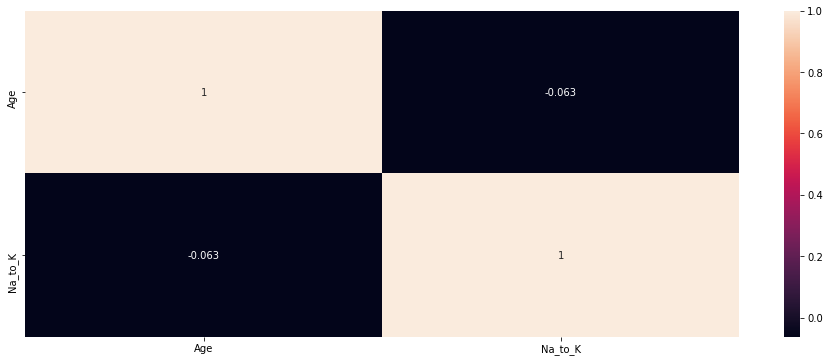

In [ ]:
plt.figure(figsize=(16,6))
heatmap = sns.heatmap(data.corr(), annot = True)

There is some correlation with age, na, and bp to target values, but no significant correlation between any features

In [ ]:
y = data.Drug.values
data = data.drop(['Drug', 'Sex', 'Cholesterol'], axis=1)

#Data Preprocessing

In [ ]:
def data_process(data, y):
  #Convert categorical to numerical labels
  ol = OrdinalEncoder()
  test = data['BP'].values.reshape(-1,1)
  data['BP'] = ol.fit_transform(test)


  le = LabelEncoder()
  y = le.fit_transform(y)

  print(ol.categories_)
  print(le.classes_)

  #Standardization for numerical features
  scaler = StandardScaler()
  data['Age'] = scaler.fit_transform(data['Age'].values.reshape(-1,1))
  data['Na_to_K'] = scaler.fit_transform(data['Na_to_K'].values.reshape(-1,1))
  return data, y

In [ ]:
X,y = data_process(data,y)
X = X.values

[array(['HIGH', 'LOW', 'NORMAL'], dtype=object)]
['DrugY' 'drugA' 'drugB' 'drugC' 'drugX']


In [ ]:
X.shape

(200, 3)

In [ ]:
y.shape

(200,)

#Model Building

In [ ]:
def build_MLP_model():
  model = Sequential()
  model.add(Dense(units = 32, activation = 'relu', input_shape = (3,), kernel_initializer = 'he_uniform', kernel_regularizer=regularizers.l2(.01)))
  model.add(Dropout(.3))
  model.add(Dense(units = 64, activation = 'relu', kernel_initializer = 'he_uniform',  kernel_regularizer=regularizers.l2(.01)))
  model.add(Dropout(.3))
  model.add(Dense(units = 128, activation = 'relu', kernel_initializer = 'he_uniform',  kernel_regularizer=regularizers.l2(.01)))
  model.add(Dropout(.3))
  model.add(Dense(units = 256, activation = 'relu', kernel_initializer = 'he_uniform',  kernel_regularizer=regularizers.l2(.01)))
  model.add(Dropout(.3))
  model.add(BatchNormalization())
  model.add(Dense(units = 5, activation = 'softmax', kernel_initializer = 'he_uniform',  kernel_regularizer=regularizers.l2(.01)))
  

  optimizer = SGD(learning_rate = .01, momentum=.9)
  model.compile(optimizer ='sgd' , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  #Use sparse because labels are in ints

  return model

In [ ]:
def build_Ridge_model():
  model = RidgeClassifier(random_state = 2)
  return model

In [ ]:
def build_PA_model():
  model = PassiveAggressiveClassifier(random_state=2)
  return model

In [ ]:
def build_Tree_model():
  model = DecisionTreeClassifier(criterion='entropy', random_state=2)
  return model

In [ ]:
def build_SVC_model():
  model = SVC(random_state=2)
  return model

In [ ]:
def build_Forest_model():
  model = RandomForestClassifier(criterion='entropy', random_state=2)
  return model

# Train and Test Model

In [ ]:
#Partition data for train, test, and validation
def model_evaluate(model, X, target, nsplits=5):
  scores = list()
  histories = list()
  X_train, X_test, y_train, y_test = train_test_split(X,target,test_size = .33, random_state = 2)
  
  es = EarlyStopping(restore_best_weights = True, min_delta = .01, patience = 2, mode = 'min')
  model_check = ModelCheckpoint('model_weights.h5', mode = 'min', save_best_only = True)

  kf = KFold(n_splits = nsplits, shuffle = True, random_state=2)
  
  for train_index, test_index in kf.split(X_train):
    
    xTrain, xTest = X_train[train_index], X_train[test_index]
    yTrain, yTest = y_train[train_index], y_train[test_index]
    
    history = model.fit(xTrain, yTrain, batch_size = 64, epochs = 100, 
                        verbose = 1, validation_data = (xTest, yTest), steps_per_epoch = 10,
                        callbacks=[es,model_check])
   
    _, acc = model.evaluate(xTest, yTest, verbose = 0)
    scores.append(acc)
    histories.append(history)
  
  model.load_weights('model_weights.h5')

  return scores, histories, X_test, y_test, model

In [ ]:
#accomdated to fit sklearn classificaiton models
def sklearnmodel_evaluate(model, X, target, nsplits=5):
  scores = list()
  histories = list()
  X_train, X_test, y_train, y_test = train_test_split(X,target,test_size = .33, random_state = 2)
  
  es = EarlyStopping(restore_best_weights = True, min_delta = .01, patience = 2, mode = 'min')
  model_check = ModelCheckpoint('model_weights.h5', mode = 'min', save_best_only = True)

  kf = KFold(n_splits = nsplits, shuffle = True, random_state=2)
  
  for train_index, test_index in kf.split(X_train):
    
    xTrain, xTest = X_train[train_index], X_train[test_index]
    yTrain, yTest = y_train[train_index], y_train[test_index]
    
    history = model.fit(xTrain, yTrain)
   
    acc = model.score(xTest, yTest)
    scores.append(acc)
    histories.append(history)
  
  #model.load_weights('model_weights.h5')

  return scores, histories, X_test, y_test, model

In [ ]:
#applicable only to keras models
def model_performance(histories, scores):
  for i in range(len(histories)):
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.set_title('Cross Entropy Loss')
    ax1.plot(histories[i].history['loss'], color = 'blue', label = 'train')
    ax1.plot(histories[i].history['val_loss'], color = 'orange', label = 'test')
    #plt.show()
    
    
    ax2.set_title('Model Accuracy')
    ax2.plot(histories[i].history['accuracy'], color = 'blue', label = 'train')
    ax2.plot(histories[i].history['val_accuracy'], color = 'orange', label = 'test')
    plt.show()
    

In [ ]:
def run_test():
  model = build_MLP_model()
  scores, histories, X_test, y_test, best_model = model_evaluate(model, X, y)
  acc = best_model.evaluate(X_test, y_test)[1] #change to evaluate[1] for keras models
  print(acc)
  return histories, scores, X_test, y_test, best_model

#Evaluate model performance

In [ ]:
histories, scores, X_test, y_test, best_model = run_test()

Epoch 1/100
10/10 [==============================] - 18s 83ms/step - loss: 11.9029 - accuracy: 0.2416 - val_loss: 10.8793 - val_accuracy: 0.5926
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 11.4811 - accuracy: 0.3374 - val_loss: 10.5224 - val_accuracy: 0.7407
Epoch 3/100
10/10 [==============================] - 0s 9ms/step - loss: 11.2390 - accuracy: 0.3587 - val_loss: 10.3986 - val_accuracy: 0.7778
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 11.0513 - accuracy: 0.3945 - val_loss: 10.3198 - val_accuracy: 0.7778
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 10.9884 - accuracy: 0.4353 - val_loss: 10.2561 - val_accuracy: 0.7778
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 10.8976 - accuracy: 0.4457 - val_loss: 10.2020 - val_accuracy: 0.8519
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 10.6954 - accuracy: 0.5360 - val_loss: 10.1498 - val_accuracy: 0.85

# Visualize Metrics

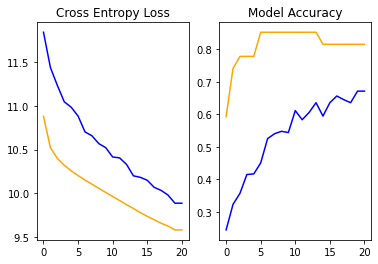

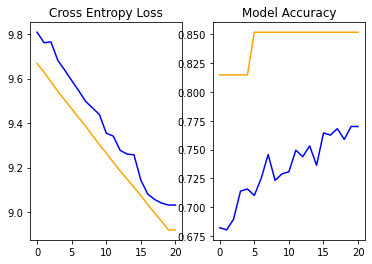

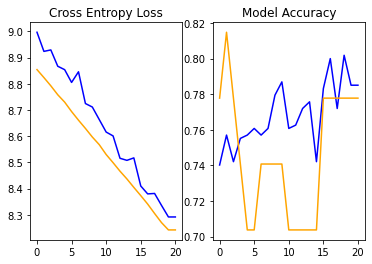

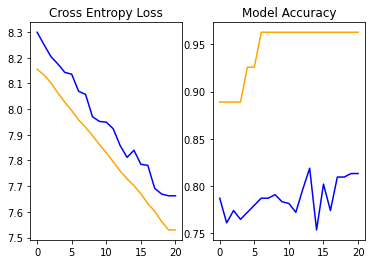

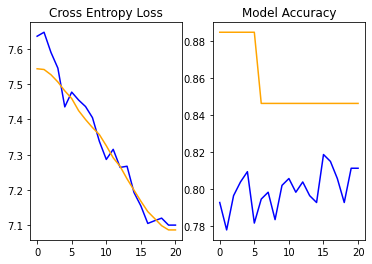

In [ ]:
model_performance(histories, scores)

In [ ]:
def build_cmatrix(X_test, y_test, best_model):
  y_pred = best_model.predict_classes(X_test)
  conf_matrix = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(conf_matrix, display_labels=None)
  disp.plot()

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TypeError: ignored

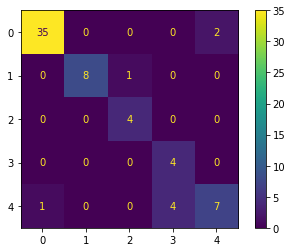

In [ ]:
build_cmatrix(X_test, y_test, best_model)

#Conclusions

All model metrics caluculated with metric 'accuracy':

*   Keras MLP with tuned hyperparameters + regularization - 89
*   Simple Ridge Classifier - 70
* Simple Passive Aggressive Classifier - 80
* Simple SVC - 71
* Simple Decision Tree - .93
* Simple Random Forest - .95

